# Clustering

In [1]:
%load_ext autoreload
%autoreload 2
import os, inspect, sys
#main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
main_dir ='C:/Users/Auk/Documents/GitHub/RGCPD'# script directory
RGCPD_func = os.path.join(main_dir, 'RGCPD')
cluster_func = os.path.join(main_dir, 'clustering')
if RGCPD_func not in sys.path:
    sys.path.append(RGCPD_func)
    sys.path.append(cluster_func)

In [4]:
%load_ext autoreload
%autoreload 2
import clustering_spatial as cl
from RGCPD import RGCPD
import plot_maps
# define input
list_of_name_path = [('fake', None),('SPI3','C:/Users/Auk/Documents/GitHub/RGCPD/data/tp_world_SPI_3.nc')]
# use RGCPD to pre-process data
rg = RGCPD(list_of_name_path=list_of_name_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
rg.pp_precursors()

Loaded pre-processed data of SPI3



In [6]:
# list_precur_pp contains name and filepath to pre-processed data 
rg.list_precur_pp

[('SPI3', 'C:/Users/Auk/Documents/GitHub/RGCPD/data/tp_world_SPI_3.nc')]

clustering fake: 0, n_clusters: 2
clustering fake: 0, n_clusters: 3


Plotting Corr maps SPI3, split 0, n_clusters 2
Plotting Corr maps SPI3, split 0, n_clusters 3


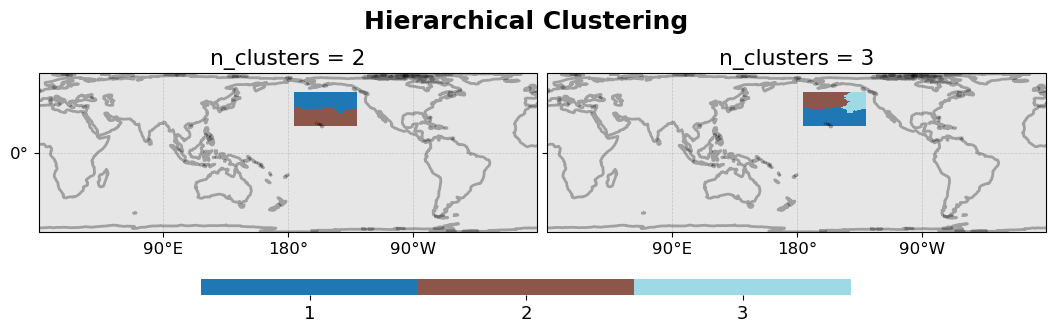

In [7]:
var_filename = rg.list_precur_pp[0][1]
mask = [185.0, 230.0, 20.0, 50.0]
q = 85
n_clusters = [2, 3]
xrclustered, results = cl.dendogram_clustering(var_filename, mask=mask, kwrgs_clust={'q':q, 'n_clusters':n_clusters})
fig = plot_maps.plot_labels(xrclustered, {'col_dim':'n_clusters', 'title':'Hierarchical Clustering'})

For more information on Dendogram clustering see:
1. McKinnon, K. A., Rhines, A., Tingley, M. P. & Huybers, P. Long-lead predictions of eastern United States hot days from Pacific sea surface temperatures. Nat. Geosci. 9, 389–394 (2016).
2. Vijverberg, S., Schmeits, M., van der Wiel, K. & Coumou, D. Sub-seasonal statistical forecasts of eastern United States hot temperature events. Mon. Weather Rev. (in print) (2020).

For other sklearn supported clustering methods, change the clustermethodkey (see sklearn.cluster.__dict__ for options) and change the setting via kwrgs_clust. 

https://scikit-learn.org/stable/modules/clustering.html

Plotting Corr maps SPI3, split 0, eps 90
Plotting Corr maps SPI3, split 0, eps 100


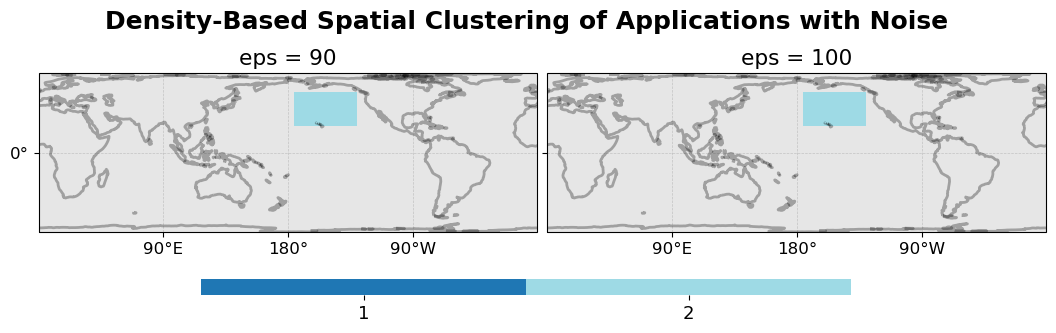

In [8]:
var_filename = rg.list_precur_pp[0][1]
mask = [185.0, 230.0, 20.0, 50.0]

xrclustered, results = cl.sklearn_clustering(var_filename, mask=mask, clustermethodkey='DBSCAN', kwrgs_clust={'eps':[90, 100]})
xrclustered += 1
fig = plot_maps.plot_labels(xrclustered, {'col_dim':'eps', 'title':'Density-Based Spatial Clustering of Applications with Noise'})



Adjustment the data that is loaded and used for the clustering by e.g. timeslicing or time-aggregation.

See core_pp.import_ds_lazy() for full functionality on loading Netcdf data

In [9]:
var_filename = rg.list_precur_pp[0][1]
mask = [185.0, 230.0, 20.0, 50.0]

xrclustered, results = cl.sklearn_clustering(var_filename, mask=mask, kwrgs_load={'tfreq':15,
                                                                                  'start_end_date':('06-01','08-31')},
                                             clustermethodkey='DBSCAN', kwrgs_clust={'eps':[8, 10]})
xrclustered += 1
fig = plot_maps.plot_labels(xrclustered, {'col_dim':'eps', 'title':'Density-Based Spatial Clustering of Applications with Noise (JJA, 15-day means)'})

clustering fake: 0, eps: 8 

ValueError: conflicting sizes for dimension 'time': length 1065 on the data but length 71 on coordinate 'time'

### To store the results (to be used by RGCPD format)

In [10]:
xrclustered.dims

('eps', 'latitude', 'longitude')

In [11]:
# select parameter(s)
eps = 8
final_cluster_output = xrclustered.sel(eps=eps).copy()
# spatial_mean_clusters will calculate an area-weighted spatial mean timeseries on the timescale and the dates 
# of the input dataset, i.e. in this case on daily timescale and year-round. 
ds = cl.spatial_mean_clusters(var_filename,
                              final_cluster_output,
                              selbox=None)
f_name = 'eps{}'.format(eps)
ds['xrclusteredall'] = xrclustered
filepath = os.path.join(rg.path_outmain, f_name)
# To store, uncomment line below
# cl.store_netcdf(ds, filepath=filepath, append_hash='dendo_'+xrclustered.attrs['hash']) 

KeyError: 8

ds now contains the original clustering output with all parameter in xrclusteredall, and the clustering output that was selected to construct the 1-timeseries (named xrclusterd). ts contains the timeseries on dims (cluster, time), with cluster referring to the cluster label. 

In [33]:
ds 

<xarray.Dataset>
Dimensions:         (cluster: 2, eps: 2, latitude: 5, longitude: 13, time: 14600)
Coordinates:
  * latitude        (latitude) float64 27.5 32.5 37.5 42.5 47.5
  * longitude       (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
    mask            (latitude, longitude) bool True True True ... True False
  * cluster         (cluster) int64 1 2
  * time            (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
  * eps             (eps) int64 8 10
Data variables:
    xrclustered     (latitude, longitude) float64 nan nan 2.0 ... 1.0 nan nan
    ts              (cluster, time) float64 0.5922 0.6283 ... -0.1208 -0.01669
    xrclusteredall  (eps, latitude, longitude) float64 nan nan 2.0 ... nan nan